In [0]:
pip install scikit-learn==1.2.2

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql import functions as F
import pandas as pd
import re
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [0]:
%sql 

select distinct 
      a.modalidade
      ,a.nomeCurso
      ,ac.`ÁREA DE CONHECIMENTO` as area_conhecimento
      ,a.MATRICULA
      ,ifnull(sum(o.tempo_consumo),0) as tempo_consumo
      ,count(distinct hist.entregas) as qtd_disciplinas
      ,ifnull(sum(qtd_tema),0) as qtd_tema
      ,qtd_consumo
      ,qtd_complementar
      ,Q1
      ,Q2
      ,Q3
      ,case when ifnull(sum(qtd_tema),0) = 0 then 0 else qtd_consumo/ifnull(sum(qtd_tema),0) end as perc_consumo
      --,e.formato
from sava_silver.alunosV2 a

left join (
            select DISTINCT a.matricula,a.periodo, a.entregas
                   from (
                            select * except(dataAtualizacao, NOME) from sava_silver.alunosv2_hst_20222
                            union
                            select * except(dataAtualizacao, NOME) from sava_silver.alunosv2_hst_20223
                            union
                            select * except(dataAtualizacao, NOME) from sava_silver.alunosv2_hst_20224
                          ) a
                          inner join (
                                      select distinct MATRICULA, periodo
                                      from sava_silver.alunosV2 a
                                      where 1=1
                                            and a.tipocurso <> 'ESPECIALIZAÇÃO'
                                            and a.marca not in ('IDOMED','IBMEC')
                                            and a.nomecurso not like '%ESPECIALI%'
                                            and a.situacao = 'Ativo'
                                            and a.entregas is not null

                                      ) at on a.matricula = at.matricula  
            WHERE A.PERIODO <> AT.PERIODO
          ) hist on a.matricula = hist.matricula 

--de para area de conheciemnto
left join (
            select * from default.cursos_por_area
          )ac on upper(a.nomecurso)=upper(ac.nom_curso)

--consumo de tema        
left join (
            select distinct 
              matriculaAluno,  sum(minutosDeAcesso) as tempo_consumo 
              ,count(distinct id_tema) as qtd_consumo               
            from sava_silver.acessosobjetosv2
            where minutosDeAcesso <> 0
            and tipo <> "CONTEUDO_COMPLEMENTAR"
            and diaAcesso between '2022-07-01' and '2022-12-31'
            group by matriculaAluno
          ) o on a.matricula = o.matriculaAluno 

--conteudo complementar
left join (
             select distinct 
               matriculaAluno,sum(minutosDeAcesso) as tempo_consumo_cc 
               ,count(distinct conteudoComplementar) as qtd_complementar             
             from sava_silver.acessosobjetosv2
             where 1=1
             and tipo = "CONTEUDO_COMPLEMENTAR"
             and diaAcesso between '2022-07-01' and '2022-12-31'
             group by matriculaAluno
          ) occ on a.matricula = occ.matriculaAluno

--tabela de turma
left join (
					 select distinct lower(id) as entrega, right(id_disciplina,7) as cod_disciplina,periodo_academico,FORMATO
					 from hive_metastore.sava_silver.entregasv2
				  ) e on hist.entregas = e.entrega

--tabela  b2b
left join (
       SELECT 
           CODIGO_DISCIPLINA, count(distinct TEMA)  as qtd_tema
       FROM (
             SELECT DISTINCT
             CONCAT(TEMA,CODIGO_DISCIPLINA) AS TEMA_DISCIPLINA
             ,ID_DO_TEMA
             ,TEMA
             ,TITULO_DO_TEMA
             ,CODIGO_DISCIPLINA
             ,NOME_DA_DISCIPLINA
             ,ORDEM
             ,TIPO_CONTEUDO
             ,case 
                 when TIPO_CONTEUDO = 'DS' then 1
                 when TIPO_CONTEUDO = 'TEMA' then 2
                 when TIPO_CONTEUDO = 'AULA' then 3
                 when TIPO_CONTEUDO = 'Laboratório' then 4
                 else 5
               end order_tipo 
             ,MIN (ORDEM) OVER (PARTITION BY ID_DO_TEMA, CODIGO_DISCIPLINA ORDER BY ORDEM ASC) AS MIN_ORDER
             ,min (
                   case 
                       when TIPO_CONTEUDO = 'DS' then 1
                       when TIPO_CONTEUDO = 'TEMA' then 2
                       when TIPO_CONTEUDO = 'AULA' then 3
                       when TIPO_CONTEUDO = 'Laboratório' then 4
                       else 5
                     end 
                   )  over (PARTITION BY ID_DO_TEMA, CODIGO_DISCIPLINA ORDER BY ORDEM ASC) as min_tipo
             FROM b2b.disciplina_temas_silver
             WHERE 1=1
               AND TIPO_CONTEUDO IN ('DS','TEMA','AULA','Laboratório')
               AND PERIODO = '2023.1'
             )

       WHERE 1=1
         and MIN_ORDER = ORDEM
         and min_tipo = order_tipo
       GROUP BY
           CODIGO_DISCIPLINA

        ) b2b on e.cod_disciplina = b2b.CODIGO_DISCIPLINA

--matriz de consumo
left join (
            SELECT 
                modalidade
                ,nomeCurso
                ,ifnull(sum(tempo_consumo),0) as tempo_consumo
                ,median(tempo_consumo) as mediana
                ,AVG(tempo_consumo) as media
                ,min(tempo_consumo) as minimo
                ,max (tempo_consumo) as maximo
                ,PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY tempo_consumo) AS Q1
                ,PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tempo_consumo) AS Q2
                ,PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY tempo_consumo) AS Q3 
            FROM default.matriz_consumo
            GROUP BY
                modalidade
                ,nomeCurso

        ) m on a.nomeCurso = m.nomeCurso and a.modalidade = m.modalidade

where 1=1
      and a.tipocurso <> 'ESPECIALIZAÇÃO'
      and a.marca not in ('IDOMED','IBMEC')
      and a.nomecurso not like '%ESPECIALI%'
      and situacao = 'Ativo'
      and a.entregas is not null

      --and a.NOMECURSO = 'DESENVOLVIMENTO FULL STACK'
      --and a.matricula = '202203312634'
      and a.modalidade = 'PRESENCIAL'

group by
      a.modalidade
      ,a.nomeCurso
      ,ac.`ÁREA DE CONHECIMENTO`
      ,a.MATRICULA 
      ,qtd_consumo
      ,qtd_complementar
      ,Q1
      ,Q2
      ,Q3

modalidade nomeCurso area_conhecimento MATRICULA tempo_consumo qtd_disciplinas qtd_tema qtd_consumo qtd_complementar Q1 Q2 Q3 perc_consumo PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 200601395738 20610 5 132 11 16 8.6752512E7 8.6752512E7 8.6752512E7 0.08333333333333333 PRESENCIAL FISIOTERAPIA SAÚDE 200901028218 16536 7 48 1 1 1.8312529E7 1.8312529E7 1.8312529E7 0.020833333333333332 PRESENCIAL ADMINISTRAÇÃO GESTÃO 201002069866 4 1 6 1 1 9544056.0 9544056.0 9544056.0 0.16666666666666666 PRESENCIAL EDUCAÇÃO FÍSICA - BACHARELADO SAÚDE 201101175192 48 3 72 2 2 5754023.0 5754023.0 5754023.0 0.027777777777777776 PRESENCIAL EDUCAÇÃO FÍSICA - LICENCIATURA SAÚDE 201201551471 102 2 21 2 9 536727.0 536727.0 536727.0 0.09523809523809523 PRESENCIAL DESIGN DE INTERIORES ECONOMIA CRIATIVA 201202030297 200 2 20 3 9 470622.0 470622.0 470622.0 0.15 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201301190217 416 4 68 3 1 8.6752512E7 8.6752512E7 8.6752512E7 0.04411764705882353 PRESENCIAL ENGENHARIA CIVIL ENGENHARIA 201301677604 14200 5 260 4 1 5478726.0 5478726.0 5478726.0 0.015384615384615385 PRESENCIAL ADMINISTRAÇÃO GESTÃO 201307074537 80 4 144 1 4 9544056.0 9544056.0 9544056.0 0.006944444444444444 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201308305133 176 1 22 4 4 8.6752512E7 8.6752512E7 8.6752512E7 0.18181818181818182 PRESENCIAL ENGENHARIA ELÉTRICA ENGENHARIA 201401186718 129 1 9 3 4 2366636.0 2366636.0 2366636.0 0.3333333333333333 PRESENCIAL ENGENHARIA CIVIL ENGENHARIA 201401188923 4260 5 216 2 1 5478726.0 5478726.0 5478726.0 0.009259259259259259 PRESENCIAL ENFERMAGEM SAÚDE 201402040377 12360 6 350 5 1 2.3598982E7 2.3598982E7 2.3598982E7 0.014285714285714285 PRESENCIAL CIÊNCIAS CONTÁBEIS GESTÃO 201402472609 4152 4 48 3 19 5450437.0 5450437.0 5450437.0 0.0625 PRESENCIAL ENGENHARIA CIVIL ENGENHARIA 201403280126 15120 5 320 4 4 5478726.0 5478726.0 5478726.0 0.0125 PRESENCIAL CIÊNCIAS CONTÁBEIS GESTÃO 201407053221 20 2 4 1 2 5450437.0 5450437.0 5450437.0 0.25 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201407392476 19450 5 140 8 1 8.6752512E7 8.6752512E7 8.6752512E7 0.05714285714285714 PRESENCIAL PSICOLOGIA SAÚDE 201408115271 2772 6 276 3 7 5.4107543E7 5.4107543E7 5.4107543E7 0.010869565217391304 PRESENCIAL PSICOLOGIA SAÚDE 201408228581 78000 10 312 34 28 5.4107543E7 5.4107543E7 5.4107543E7 0.10897435897435898 PRESENCIAL ADMINISTRAÇÃO GESTÃO 201408324717 279552 7 468 23 8 9544056.0 9544056.0 9544056.0 0.049145299145299144 PRESENCIAL ENGENHARIA DE CONTROLE E AUTOMAÇÃO ENGENHARIA 201451375743 24 3 22 2 4 556452.0 556452.0 556452.0 0.09090909090909091 PRESENCIAL NUTRIÇÃO SAÚDE 201502110938 62532 3 192 6 7 1.5385061E7 1.5385061E7 1.5385061E7 0.03125 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201503101592 48 4 129 2 6 8.6752512E7 8.6752512E7 8.6752512E7 0.015503875968992248 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201505443334 672 8 33 5 7 8.6752512E7 8.6752512E7 8.6752512E7 0.15151515151515152 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201505454751 405 5 50 5 4 8.6752512E7 8.6752512E7 8.6752512E7 0.1 PRESENCIAL ANÁLISE E DESENVOLVIMENTO DE SISTEMAS TECNOLOGIA DA INFORMAÇÃO 201506158935 588 4 75 4 3 4208600.0 4208600.0 4208600.0 0.05333333333333334 PRESENCIAL EDUCAÇÃO FÍSICA - BACHARELADO SAÚDE 201509198415 1392 6 208 6 4 5754023.0 5754023.0 5754023.0 0.028846153846153848 PRESENCIAL NUTRIÇÃO SAÚDE 201512215554 3996 3 198 5 1 1.5385061E7 1.5385061E7 1.5385061E7 0.025252525252525252 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201512584861 320 4 165 2 6 8.6752512E7 8.6752512E7 8.6752512E7 0.012121212121212121 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201551296063 31581 9 407 3 11 8.6752512E7 8.6752512E7 8.6752512E7 0.007371007371007371 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201601485972 618 1 11 12 4 8.6752512E7 8.6752512E7 8.6752512E7 1.0909090909090908 PRESENCIAL PSICOLOGIA SAÚDE 201601536501 234 6 42 1 13 5.4107543E7 5.4107543E7 5.4107543E7 0.023809523809523808 PRESENCIAL ENFERMAGEM SAÚDE 201601583834 90432 8 504 34 2 2.3598982E7 2.3598982E7 2.3598982E7 0.06746031746031746 PRESENCIAL CIÊNCIAS CONTÁB

In [0]:
_sqldf = _sqldf.where((F.col("area_conhecimento") == "SAÚDE") | (F.col("area_conhecimento") == "ENGENHARIA") | (F.col("area_conhecimento") == "CIÊNCIAS JURÍDICAS"))
_sqldf.na.drop()


Out[3]: DataFrame[modalidade: string, nomeCurso: string, area_conhecimento: string, MATRICULA: string, tempo_consumo: bigint, qtd_disciplinas: bigint, qtd_tema: bigint, qtd_consumo: bigint, qtd_complementar: bigint, Q1: double, Q2: double, Q3: double, perc_consumo: double]

In [0]:
display(_sqldf)

modalidade nomeCurso area_conhecimento MATRICULA tempo_consumo qtd_disciplinas qtd_tema qtd_consumo qtd_complementar Q1 Q2 Q3 perc_consumo PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 200601395738 20610 5 132 11 16 8.6752512E7 8.6752512E7 8.6752512E7 0.08333333333333333 PRESENCIAL FISIOTERAPIA SAÚDE 200901028218 16536 7 48 1 1 1.8312529E7 1.8312529E7 1.8312529E7 0.020833333333333332 PRESENCIAL EDUCAÇÃO FÍSICA - BACHARELADO SAÚDE 201101175192 48 3 72 2 2 5754023.0 5754023.0 5754023.0 0.027777777777777776 PRESENCIAL EDUCAÇÃO FÍSICA - LICENCIATURA SAÚDE 201201551471 102 2 21 2 9 536727.0 536727.0 536727.0 0.09523809523809523 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201301190217 416 4 68 3 1 8.6752512E7 8.6752512E7 8.6752512E7 0.04411764705882353 PRESENCIAL ENGENHARIA CIVIL ENGENHARIA 201301677604 14200 5 260 4 1 5478726.0 5478726.0 5478726.0 0.015384615384615385 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201308305133 176 1 22 4 4 8.6752512E7 8.6752512E7 8.6752512E7 0.18181818181818182 PRESENCIAL ENGENHARIA ELÉTRICA ENGENHARIA 201401186718 129 1 9 3 4 2366636.0 2366636.0 2366636.0 0.3333333333333333 PRESENCIAL ENGENHARIA CIVIL ENGENHARIA 201401188923 4260 5 216 2 1 5478726.0 5478726.0 5478726.0 0.009259259259259259 PRESENCIAL ENFERMAGEM SAÚDE 201402040377 12360 6 350 5 1 2.3598982E7 2.3598982E7 2.3598982E7 0.014285714285714285 PRESENCIAL ENGENHARIA CIVIL ENGENHARIA 201403280126 15120 5 320 4 4 5478726.0 5478726.0 5478726.0 0.0125 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201407392476 19450 5 140 8 1 8.6752512E7 8.6752512E7 8.6752512E7 0.05714285714285714 PRESENCIAL PSICOLOGIA SAÚDE 201408115271 2772 6 276 3 7 5.4107543E7 5.4107543E7 5.4107543E7 0.010869565217391304 PRESENCIAL PSICOLOGIA SAÚDE 201408228581 78000 10 312 34 28 5.4107543E7 5.4107543E7 5.4107543E7 0.10897435897435898 PRESENCIAL ENGENHARIA DE CONTROLE E AUTOMAÇÃO ENGENHARIA 201451375743 24 3 22 2 4 556452.0 556452.0 556452.0 0.09090909090909091 PRESENCIAL NUTRIÇÃO SAÚDE 201502110938 62532 3 192 6 7 1.5385061E7 1.5385061E7 1.5385061E7 0.03125 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201503101592 48 4 129 2 6 8.6752512E7 8.6752512E7 8.6752512E7 0.015503875968992248 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201505443334 672 8 33 5 7 8.6752512E7 8.6752512E7 8.6752512E7 0.15151515151515152 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201505454751 405 5 50 5 4 8.6752512E7 8.6752512E7 8.6752512E7 0.1 PRESENCIAL EDUCAÇÃO FÍSICA - BACHARELADO SAÚDE 201509198415 1392 6 208 6 4 5754023.0 5754023.0 5754023.0 0.028846153846153848 PRESENCIAL NUTRIÇÃO SAÚDE 201512215554 3996 3 198 5 1 1.5385061E7 1.5385061E7 1.5385061E7 0.025252525252525252 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201512584861 320 4 165 2 6 8.6752512E7 8.6752512E7 8.6752512E7 0.012121212121212121 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201551296063 31581 9 407 3 11 8.6752512E7 8.6752512E7 8.6752512E7 0.007371007371007371 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201601485972 618 1 11 12 4 8.6752512E7 8.6752512E7 8.6752512E7 1.0909090909090908 PRESENCIAL PSICOLOGIA SAÚDE 201601536501 234 6 42 1 13 5.4107543E7 5.4107543E7 5.4107543E7 0.023809523809523808 PRESENCIAL ENFERMAGEM SAÚDE 201601583834 90432 8 504 34 2 2.3598982E7 2.3598982E7 2.3598982E7 0.06746031746031746 PRESENCIAL FISIOTERAPIA SAÚDE 201601704331 180144 9 2124 26 2 1.8312529E7 1.8312529E7 1.8312529E7 0.01224105461393597 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201602705534 76 4 43 2 2 8.6752512E7 8.6752512E7 8.6752512E7 0.046511627906976744 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201602795746 13728 4 51 15 8 8.6752512E7 8.6752512E7 8.6752512E7 0.29411764705882354 PRESENCIAL ENGENHARIA CIVIL ENGENHARIA 201602837783 90336 6 544 34 7 5478726.0 5478726.0 5478726.0 0.0625 PRESENCIAL NUTRIÇÃO SAÚDE 201603203575 315 3 39 1 3 1.5385061E7 1.5385061E7 1.5385061E7 0.02564102564102564 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201603422994 13384 8 196 6 7 8.6752512E7 8.6752512E7 8.6752512E7 0.030612244897959183 PRESENCIAL DIREITO CIÊNCIAS JURÍDICAS 201607231204 14700 7 198 6 5 8.6752512E7 8.6752512E7 8.6752512E7 0.030303

In [0]:
_sqldf= _sqldf.drop("modalidade","nomeCurso", "MATRICULA", "qtd_consumo", "qtd_tema", "qtd_complementar", "Q1", "Q2", "Q3", "perc_consumo")

In [0]:
sample = _sqldf.sample(withReplacement = False, fraction = 0.01, seed = 10)
sample = sample.drop("area_conhecimento")

In [0]:
sample.count()

Out[7]: 699

In [0]:
display(sample)

tempo_consumo qtd_disciplinas 96 3 68600 8 66456 9 2070 6 3648 4 86768 4 3645 5 4656 4 0 0 3584 8 0 2 36 3 0 3 0 0 756 3 6232 4 0 6 24 3 0 8 0 5 6300 5 0 7 0 6 8340 5 2940 4 828 3 19248 4 0 6 2496 4 384 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 70 7 420 5 25620 5 8000 5 24 2 880 4 11760 4 128 4 156 0 90 3 300 2 0 4 0 1 0 3 0 6 108 4 0 1 0 5 216 3 0 6 686 7 0 6 0 10 0 9 19625 5 32175 5 864 6 4752 3 20060 4 10332 3 0 3 128 4 0 5 159840 8 0 11 798 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 5250 6 72 6 11460 5 19752 4 3360 4 195 5 0 0 0 3 0 0 0 0 36 4 0 9 0 5 0 13 0 7 240 5 0 8 0 5 228 0 30672 4 660 3 3066 6 3860 5 15440 4 48 3 4690 5 21072 4 8592 4 32 4 688 4 340 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 30980 4 62064 6 2214 3 120 5 504 3 1038 3 108 3 3560 5 0 1 61968 3 8730 3 21411 3 18648 4 270 6 0 4 16116 4 22330 10 0 7 4968 4 384 4 4788 3 24 3 0 3 6024 4 1125 3 0 0 4680 6 25872 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1890 3 420 6 30 5 12192 4 1344 6 150 5 282 3 672 4 6425 5 52480 4 0 4 360 18 2112 6 700 5 5660 4 891 9 0 7 0 0 0 1 0 8 20 5 0 10 0 5 10225 5 0 8 2800 5 24480 12 0 4 0 4 46272 4 32 4 9288 4 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 833 7 39312 8 160 8 2240 4 4672 4 8775 5 23904 6 12800 4 0 5 0 0 0 3 0 6 0 0 660 4 0 6 0 0 0 5 0 6 0 5 2502 3 2856 4 0 6 42000 6 0 7 2718 3 0 6 4014 3 1888 4 0 4 87840 5 5340 4 0 4 3264 4 336 4 13050 5 208 4 9840 4 1504 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15645 7 2232 4 32700 5 11550 5 352 4 6048 4 1120 4 0 6 100 4 0 1 23450 7 24150 7 0 2 0 9 6720 4 840 7 0 6 16050 5 3900 5 75 5 0 8 0 4 0 4 6156 4 1284 4 16624 4 12432 6 4368 4 0 4 0 7 3975 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 120840 5 2616 2 36 4 1548 4 18752 4 76788 4 0 0 0 0 0 5 0 16 1600 8 0 0 1320 2 0 2 0 5 0 2 0 9 58 1 0 7 0 5 9390 5 0 7 3780 5 105 7 0 8 2412 4 29950 5 0 5 35 7 0 4 0 4 0 4 0 0 16578 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 52340 4 1840 1 41400 5 1488 4 9144 4 228 4 3231 2 0 0 0 3 288 0 0 5 0 8 17976 12 0 5 10048 2 0 5 4440 6 5275 5 4896 8 0 5 20960 4 0 6 0 5 0 6 0 8 0 6 0 4 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 60336 6 1872 3 21024 8 89082 6 18 6 4100 5 50032 4 2304 4 3024 4 1260 5 27625 5 19012 7 0 1 162 1 0 2 0 0 0 9 108 2 1584 6 34398 7 0 8 0 4 0 9 0 7 14624 4 2560 4 612 3 3136 4 0 5 1368 4 13095 5 1488 4 0 0 0 0 0 0 0 0 0 0 26928 4 36 6 1800 4 4131 9 1720 2 1080 5 16256 4 6520 4 10296 4 0 1 0 4 0 1 5400 10 0 4 0 6 3366 11 0 6 19512 3 0 0 3360 5 2928 8 0 9 1600 5 0 6 9415 7 0 6 0 10 288 4 930 3 0 4 0 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 22464 4 140 10 720 6 924 6 32967 3 15885 5 65050 5 161712 6 1104 4 324 3 0 0 7850 4 0 2 128 8 34050 5 0 8 0 5 0 0 3350 5 0 7 0 7 0 4 24800 4 0 6 2880 5 0 4 0 4 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1168 4 10410 6 28800 6 28400 5 68250 5 900 3 9344 4 88140 4 36 4 0 4 1128 4 0 2 3648 4 52596 6 420 7 0 0 208656 6 375 5 18896 4 5886 3 0 4 2120 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 13050 5 42975 5 10950 5 162 9 2750 5 28140 6 133632 6 18540 6 44064 4 2752 4 896 4 0 2 0 2 1296 6 0 0 0 2 0 0 180 5 0 2 1782 3 882 6 28602 6 0 10 0 6 0 6 0 8 0 9 805 5 0 0 30415 7 36 1 0 6 4680 4 0 7 22260 7 504 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 134190 7 8050 5 23560 10 3600 6 48090 5 208512 4 6536 4 4239 3 0 2 0 3 756 6 58176 6 1248 3 0 5 0 6 5952 4 0 4 6875 5 0 0 0 3 0 5 0 6 0 0 0 0 0 0 0 0 240 5 2808 6 280 7 13680 6 7632 3 2432 4 1584 4 15456 4 720 2 1792 4 0 0 0 7 0 0 192 2 0 2 5490 10 0 4 0 0 0 5 0 0 0 9 504 6 0 6 0 6 0 7 0 3 0 5 0 4 6850 5 4980 4 0 4 27024 4 10176 4 1072 4 25440 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11628 6 1232 8 17680 4 140 4 9765 7 0 5 1680 4 4750 5 80 4 0 9 42 7 25776 4 4848 8 1856 4 24200 4 4608 4 220 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [0]:
sample_p = sample.toPandas()

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sample_p)

In [0]:
k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
k_means.fit(scaled_features)
label = k_means.fit_predict(scaled_features)
centroids = k_means.cluster_centers_
print(centroids)

[[-0.03321749  0.62130032]
 [-0.32015112 -1.10591053]
 [ 4.75744414  0.75607135]]


In [0]:
#label

Out[28]: array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 3,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0,

In [0]:
pd.DataFrame(scaled_features)

0 
 1 
 
 
 
 
 0 
 -0.320203 
 -0.155510 
 
 
 1 
 3.048732 
 1.564455 
 
 
 2 
 2.943293 
 1.908448 
 
 
 3 
 -0.223124 
 0.876469 
 
 
 4 
 -0.145520 
 0.188483 
 
 
 ... 
 ... 
 ... 
 
 
 694 
 -0.324924 
 -1.187490 
 
 
 695 
 -0.324924 
 -1.187490 
 
 
 696 
 -0.324924 
 -1.187490 
 
 
 697 
 -0.324924 
 -1.187490 
 
 
 698 
 -0.324924 
 -1.187490 
 
 
 
 699 rows × 2 columns

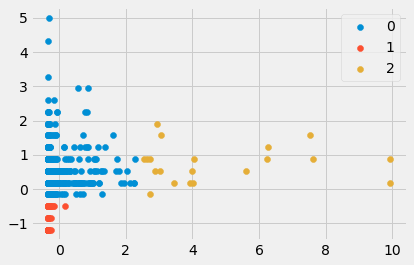

In [0]:
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(scaled_features[label == i , 0] , scaled_features[label == i , 1] , label = i)
plt.legend()
plt.show()

In [0]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

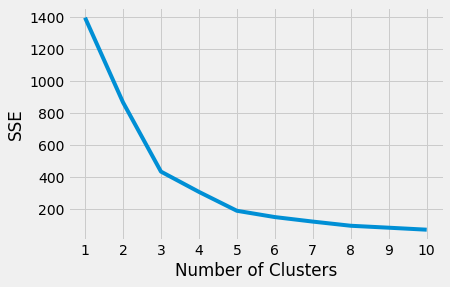

In [0]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()